## NBIC Workflow Provena Toy Example

This relies on some pre-registered components and is intended to show an example provenance enabled workflow by integrating with the provena APIs. 

The actual computation/validation has been stripped from the source notebook - but hopefully it will be clear where this can be reintroduced

### Provena workflow configuration setup

In [1]:
# This is a small helper class which provides a config object for validation and
# a loader function
import jy_workflow_config

# this contains helpers for interacting with the registry
import registry

# This is a helper function for managing authentication with Provena
import mdsisclienttools.auth.TokenManager as ProvenaAuth


import json
import time
import requests


In [2]:
# Provena config
stage = "DEV"
kc_endpoint = "https://auth.dev.provena.nbic.cloud/auth/realms/provena"
registry_endpoint = "https://registry-api.dev.provena.nbic.cloud"
provenance_endpoint = "https://prov-api.dev.provena.nbic.cloud"
data_store_endpoint = "https://data-api.dev.provena.nbic.cloud"

In [8]:
# sets up auth connections - could potentially open browser window if not signed
# in recently - caches in .tokens.json - ensure this is included in gitignore
provena_auth = ProvenaAuth.DeviceFlowManager(
    stage=stage,
    keycloak_endpoint=kc_endpoint
)

# expose the get auth function which is used for provena methods 
get_auth = provena_auth.get_auth

No storage or object provided, using default location: .tokens.json.
Using storage type: FILE.
Using DEVICE auth flow.
Attempting to generate authorisation tokens.

Looking for existing tokens in local storage.

No local storage tokens for stage DEV found.

Initiating device auth flow to generate access and refresh tokens.

Decoding response

Please authorise using the following endpoint.

Verification URL: https://auth.dev.provena.nbic.cloud/auth/realms/provena/device?user_code=VDCI-IDYE
User Code: VDCI-IDYE

Awaiting completion


Token generation complete. Authorisation successful.



In [9]:
# Start by loading the config from the specified path 

# NOTE this could change from run to run - this holds all information required to run this model
config_path = "configs/jy_example_workflow.json"
config = jy_workflow_config.load_config(path=config_path)
config.pprint()


{
  "inputs": {
    "hourly_temperature": "10378.1/1730504",
    "hourly_temperature_template": "10378.1/1730516"
  },
  "outputs": {
    "hourly_jyi": "10378.1/1730515",
    "hourly_jyi_template": "10378.1/1730517"
  },
  "associations": {
    "person": "10378.1/1723017",
    "organisation": "10378.1/1727883"
  },
  "workflow_configuration": {
    "workflow_template": "10378.1/1730519"
  }
}


In [10]:
# let's validate the workflow config - this fetches ALL items referenced in the
# workflow json to ensure the items are valid 
valid = config.validate_entities(registry_endpoint=registry_endpoint, auth=get_auth)

if not valid:
    print("FAILED VALIDATION")
    raise Exception("Workflow config validation exception occurred. See output above.")


Validating registered Provena entities in config
Validating registered input datasets...
Fetching from registry, id: 10378.1/1730504...
Fetching from registry, id: 10378.1/1730516...
Validating registered output datasets...
Fetching from registry, id: 10378.1/1730515...
Fetching from registry, id: 10378.1/1730517...
Validating registered associations...
Fetching from registry, id: 10378.1/1723017...
Fetching from registry, id: 10378.1/1727883...
Validating registered associations...
Fetching from registry, id: 10378.1/1730519...
Validation successful...


## Model run integration
Now that the validation of the workflow configuration (incl. registered entitites) is complete - we can move into the example of running the model against this configuration.

### Data paths

Let's consider how data can be loaded. 

This example is straight from the notebook: 

```python
temperature = xr.open_zarr(nbic.catalog_s3_stage1.weather.projected.to_path('AU_hourly_temperature_C.zarr'), chunks='auto')
```

In this case we have a mechanism to reference the variable part of the data path, but hardcode the zarr file path. 

We could continue to operate in this manner, or we could utilise the external reposited path metadata in the registered dataset instead. I will demonstrate this below.

In [11]:
# let's establish the paths of the input from the dataset
def pprint_json(content) -> None:
    print(json.dumps(content,indent=2))

# fetch the dataset 
ds_id = config.inputs.hourly_temperature
fetched_ds = registry.fetch_dataset(registry_endpoint=registry_endpoint, id=ds_id, auth=get_auth())
pprint_json(fetched_ds)

Fetching from registry, id: 10378.1/1730504...
{
  "display_name": "Hourly temperature",
  "collection_format": {
    "associations": {
      "organisation_id": "10378.1/1727883"
    },
    "dataset_info": {
      "name": "Hourly temperature",
      "description": "Hourly temperature test dataset ",
      "access_info": {
        "reposited": true,
        "uri": null,
        "description": null
      },
      "publisher_id": "10378.1/1727883",
      "created_date": "2023-08-11",
      "published_date": "2023-08-11",
      "license": "https://gbrrestoration.github.io/rrap-mds-knowledge-hub/information-system/licenses.html#copyright-all-rights-reserved-",
      "preferred_citation": null,
      "keywords": null,
      "version": null
    },
    "approvals": {
      "ethics_registration": {
        "relevant": false,
        "obtained": false
      },
      "ethics_access": {
        "relevant": false,
        "obtained": false
      },
      "indigenous_knowledge": {
        "relevant"

In [12]:
# determine the external reposit path
file_path = fetched_ds["collection_format"]["dataset_info"]["access_info"]["uri"]
print(file_path)

None


As demonstrated above, it is possible to retrieve the associated file path from the registered Dataset (assuming this info was included at registration time). Or the existing file path mechanism could continue being used.

A similar approach works for the other inputs. Shown below.

In [15]:
def fetch_and_path(id: str):
    dataset = registry.fetch_dataset(registry_endpoint=registry_endpoint, id=id, auth=get_auth())
    path = dataset["collection_format"]["dataset_info"]["access_info"]["uri"]
    return dataset, path

# temperature
temperature_ds, temperature_path = fetch_and_path(id=config.inputs.hourly_temperature)

pprint_json({
   "Temperature: " : temperature_path
})

Fetching from registry, id: 10378.1/1730504...
{
  "Temperature: ": null
}


Alternatively, if we wanted to use the data storage utilities of the Provena data store, we could register a reposited dataset, and use the dynamic credential generation to produce r or r/w credentials into that specific dataset.

### Running our fake model

We are going to pretend to produce some output from this process.

In [16]:
def fake_data_fetch(path: str) -> int:
    # This method would take the path and return the data
    return 0

fake_temperature = fake_data_fetch(temperature_path)


def fake_model(temperature: int) -> int:
    # this model does some heavy lifting and takes 10 seconds to finish 
    time.sleep(10) 
    
    return 0

# let's run our model with the inputs 

# start timer
start_time = int(time.time())

# run the model 
fake_model_output = fake_model(
    temperature=fake_temperature    
)

end_time = int(time.time())

print(f"Ran fake hourly JYI calculation, took {end_time - start_time} seconds.")



Ran fake hourly JYI calculation, took 10 seconds.


Now we have ran the toy model, let's register a provenance record which records the model run, the inputs used, and the outputs produced.

We need to think more about the output. 

There are two primary ways that Provena supports registering the results of a model run. 

1. Dynamically register a new Dataset and link to this dataset. This is the _preferred_ method as it creates a clear causal chain between the model and the output dataset.
2. Use a deferred or defined resource in an output dataset template to register the outputs into an existing dataset. E.g. overwrite an existing file or contribute new files to an existing dataset. This method produces less structurally clear provenance chains and may obfuscate the history of data (if overwriting).

We will show both methods. Method 2) is more closely aligned with the existing data path workflow in NBIC.

Model runs satisfy the following JSON schema

```json
{
  "workflow_template_id": "string",
  "inputs": [
    {
      "dataset_template_id": "string",
      "dataset_id": "string",
      "dataset_type": "DATA_STORE",
      "resources": {
        "additionalProp1": "string",
        "additionalProp2": "string",
        "additionalProp3": "string"
      }
    }
  ],
  "outputs": [
    {
      "dataset_template_id": "string",
      "dataset_id": "string",
      "dataset_type": "DATA_STORE",
      "resources": {
        "additionalProp1": "string",
        "additionalProp2": "string",
        "additionalProp3": "string"
      }
    }
  ],
  "annotations": {
    "additionalProp1": "string",
    "additionalProp2": "string",
    "additionalProp3": "string"
  },
  "description": "string",
  "associations": {
    "modeller_id": "string",
    "requesting_organisation_id": "string"
  },
  "start_time": 0,
  "end_time": 0
}
```

#### Overwrite an existing output at a specified path

Let's start with method 2) and overwrite a specified output. This dataset is pre-registered and is included in our config.

In [17]:
### Overwrite existing output

output_dataset_id = config.outputs.hourly_jyi

# we can resolve the path using the same approach as above, or using existing
# NBIC path structure

output_ds, output_path =fetch_and_path(id=output_dataset_id)

pprint_json(output_ds)

Fetching from registry, id: 10378.1/1730515...


{
  "display_name": "Hourly JY Index",
  "collection_format": {
    "associations": {
      "organisation_id": "10378.1/1727883"
    },
    "dataset_info": {
      "name": "Hourly JY Index",
      "description": "Hourly JY (Jonathan Yu) Index",
      "access_info": {
        "reposited": true,
        "uri": null,
        "description": null
      },
      "publisher_id": "10378.1/1727883",
      "created_date": "2023-08-11",
      "published_date": "2023-08-11",
      "license": "https://gbrrestoration.github.io/rrap-mds-knowledge-hub/information-system/licenses.html#copyright-all-rights-reserved-",
      "preferred_citation": null,
      "keywords": null,
      "version": null
    },
    "approvals": {
      "ethics_registration": {
        "relevant": false,
        "obtained": false
      },
      "ethics_access": {
        "relevant": false,
        "obtained": false
      },
      "indigenous_knowledge": {
        "relevant": false,
        "obtained": false
      },
      "expor

In [18]:
# building the model run payload 
model_run_payload = {
  # This specifies the workflow template we are using 
  "workflow_template_id": config.workflow_configuration.workflow_template,
  
  # here we specify a dataset to match each template, and optionally any
  # deferred resources
  "inputs": [
    # temperature
    {
      "dataset_template_id": config.inputs.hourly_temperature_template,
      "dataset_id": config.inputs.hourly_temperature,
      "dataset_type": "DATA_STORE"      
    }
  ],
  "outputs": [
    # Hourly JYI output
    {
      "dataset_template_id": config.outputs.hourly_jyi_template,
      "dataset_id": config.outputs.hourly_jyi,
      "dataset_type": "DATA_STORE"      
    },
  ],
  "description": "HourlyJYI Workflow. JY example. This is an example of using the JYI workflow to register into an existing dataset.",
  "associations": {
    "modeller_id": config.associations.person,
    "requesting_organisation_id": config.associations.organisation
  },
  "start_time": start_time, 
  "end_time": end_time
}

In [19]:
# Registering the model run 
endpoint = provenance_endpoint + "/model_run/register_complete"
payload = model_run_payload

# send off request
print("Registering model run")
response = requests.post(url=endpoint, json=payload, auth=get_auth())

# use helper function to check response
registry.check_response(response=response, status_check=True)

response_content = response.json()
method_two_record_info = response_content["record_info"]
pprint_json(method_two_record_info)


Registering model run
Token validation failed due to error: Signature has expired.
Refreshing using refresh token

{
  "id": "10378.1/1730530",
  "prov_json": "{\"prefix\": {\"default\": \"http://hdl.handle.net/\"}, \"activity\": {\"10378.1/1730530\": {\"model_run/10378.1/1730530\": true, \"item_category\": \"ACTIVITY\", \"item_subtype\": \"MODEL_RUN\"}}, \"entity\": {\"10378.1/1730504\": {\"model_run/10378.1/1730530\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET\"}, \"10378.1/1730515\": {\"model_run/10378.1/1730530\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET\"}, \"10378.1/1730519\": {\"model_run/10378.1/1730530\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"MODEL_RUN_WORKFLOW_TEMPLATE\", \"prov:type\": {\"$\": \"prov:Collection\", \"type\": \"prov:QUALIFIED_NAME\"}}, \"10378.1/1730516\": {\"model_run/10378.1/1730530\": true, \"item_category\": \"ENTITY\", \"item_subtype\": \"DATASET_TEMPLATE\"}, \"10378.1/1730517\": {\"model_ru

Quick and dirty visualisation

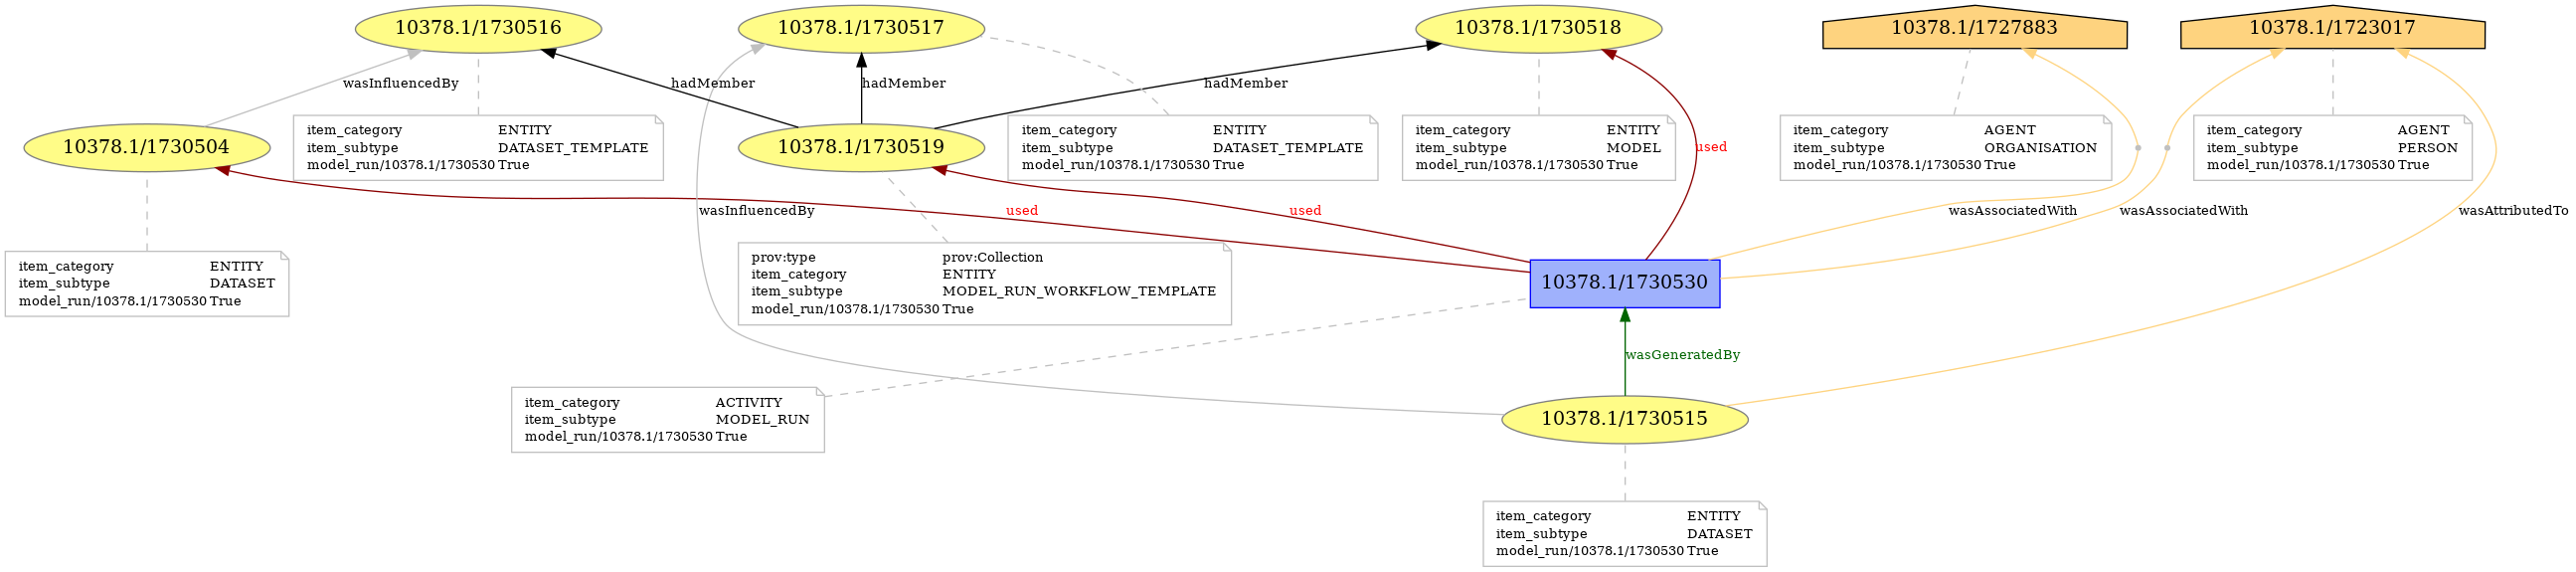

In [20]:
import prov.model as pm
from prov.dot import prov_to_dot
from IPython.display import Image

# pull out json serialisation from prov api
prov_serialisation = method_two_record_info["prov_json"]

# parse into prov document
document = pm.ProvDocument.deserialize(source=None, content=prov_serialisation)

# render into file
dot = prov_to_dot(document)
name = "resources/prov_graph"

dot.write_png(name + '.png')
Image(name + '.png')

#### Registering a dataset during model run registration

Now let's perform method 1) i.e. register a dataset during automated model run provenance registration.

Datasets require the following fields.


```json
{
  "associations": {
    "organisation_id": "string"
  },
  "dataset_info": {
    "name": "string",
    "description": "string",
    "access_info": {
      "reposited": true,
      "uri": "string",
      "description": "string"
    },
    "publisher_id": "string",
    "created_date": "2023-06-06",
    "published_date": "2023-06-06",
    "license": "string",
    "preferred_citation": "string",
    "keywords": [
      "string"
    ],
    "version": "string"
  },
  "approvals": {
    "ethics_registration": {
      "relevant": false,
      "obtained": false
    },
    "ethics_access": {
      "relevant": false,
      "obtained": false
    },
    "indigenous_knowledge": {
      "relevant": false,
      "obtained": false
    },
    "export_controls": {
      "relevant": false,
      "obtained": false
    }
  }
}
```

In [22]:
default_license = "https://gbrrestoration.github.io/rrap-mds-knowledge-hub/information-system/licenses.html#copyright-all-rights-reserved"
output_path = "s3://nbic-stage-2/test-data.csv"
dataset_payload = {
  "associations": {
    "organisation_id": config.associations.organisation
  },
  "dataset_info": {
    "name": "Hourly JYI Example workflow output",
    "description": "Hourly JYI Example workflow output. Generated in automated provenance workflow registration. Externally reposited file with jyi outputs.",
    
    # The data is not reposited
    "access_info": {
      "reposited": False,
      "uri": output_path,
      "description": "The  file is stored in the NBIC S3 storage at the specified path"
    },
    "publisher_id": config.associations.organisation,
    "created_date": "2023-06-06",
    "published_date": "2023-06-06",
    "license": default_license,
    "keywords": [
        "JYI",
        "Example"
    ]
  },
  "approvals": {
    "ethics_registration": {
      "relevant": False,
      "obtained": False
    },
    "ethics_access": {
      "relevant": False,
      "obtained": False
    },
    "indigenous_knowledge": {
      "relevant": False,
      "obtained": False
    },
    "export_controls": {
      "relevant": False,
      "obtained": False
    }
  }
}

# Registering the dataset
endpoint = data_store_endpoint + "/register/mint-dataset"
payload = dataset_payload

# send off request
print("Registering output dataset")
response = requests.post(url=endpoint, json=payload, auth=get_auth())

# use helper function to check response
registry.check_response(response=response, status_check=True)

response_content = response.json()
output_dataset_id = response_content["handle"]

print(f"Minted new dataset successfully with handle {output_dataset_id}.")

Registering output dataset
Minted new dataset successfully with handle 10378.1/1730532.


Now we have dynamically generated an output dataset. 

We could choose to actually upload the files to this dataset using the dynamic s3 credential generation. 

However, in the NBIC workflows we just want to refer to the existing storage location - so we use the externally reposited option as above to specify this path. 

Now we can use the same model run payload, replacing the output dataset with the dynamically generated output above.

Registering model run


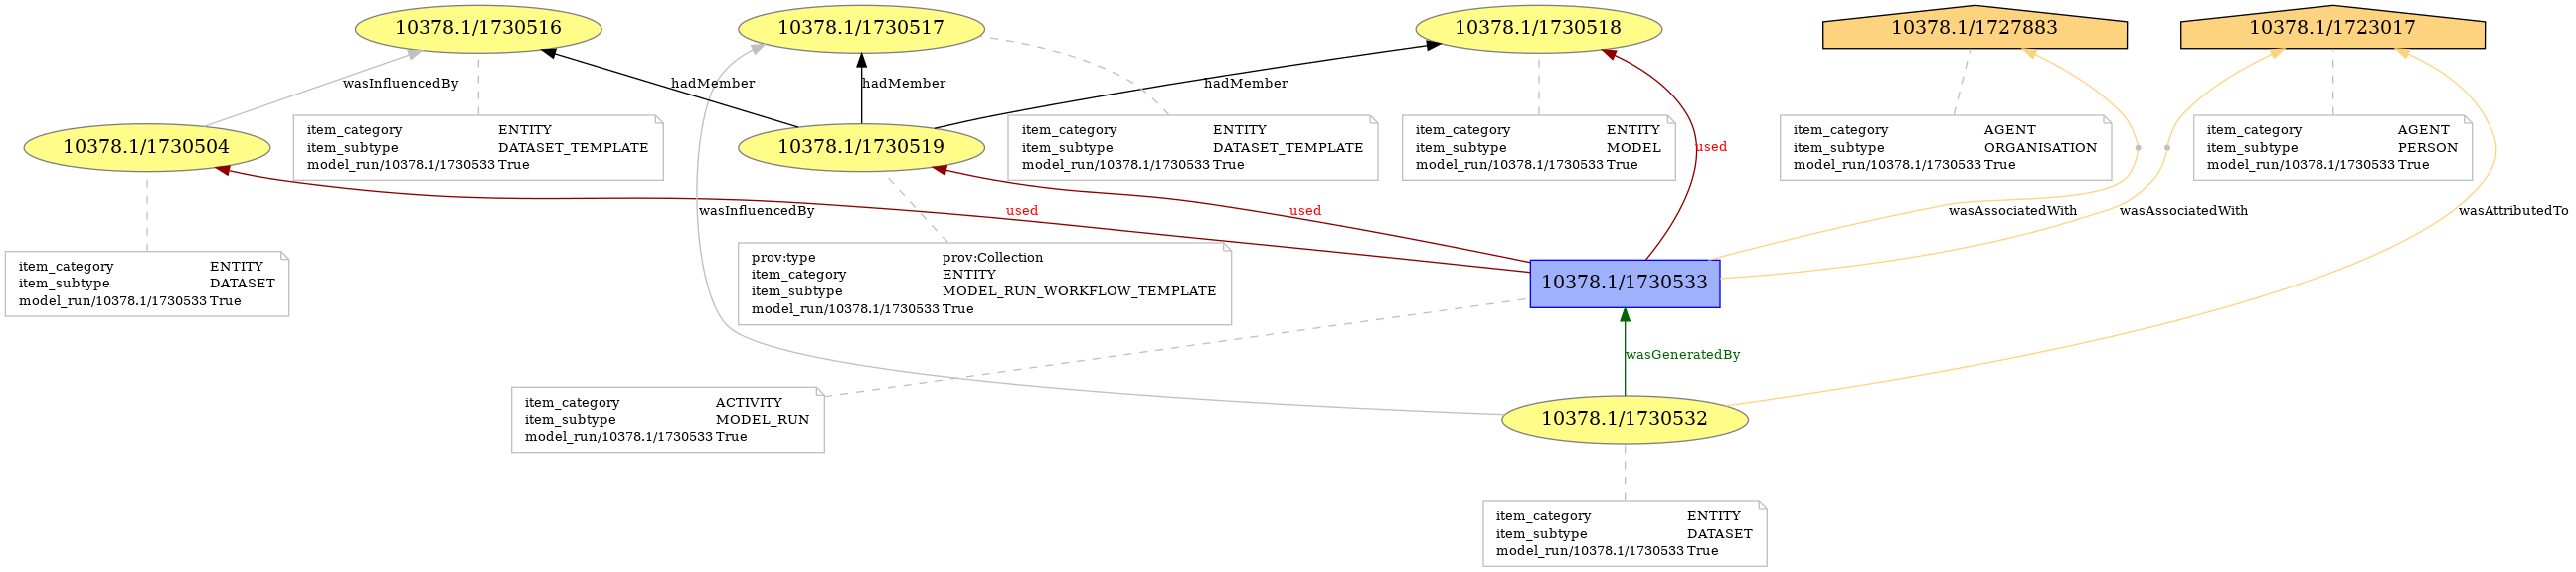

In [23]:
# update the dataset ID 
model_run_payload["outputs"][0]["dataset_id"] = output_dataset_id


## Registering the model run 
endpoint = provenance_endpoint + "/model_run/register_complete"
payload = model_run_payload

# send off request
print("Registering model run")
response = requests.post(url=endpoint, json=payload, auth=get_auth())

# use helper function to check response
registry.check_response(response=response, status_check=True)

response_content = response.json()
method_one_record_info = response_content["record_info"]

# pull out json serialisation from prov api
prov_serialisation = method_one_record_info["prov_json"]

# parse into prov document
document = pm.ProvDocument.deserialize(source=None, content=prov_serialisation)

# render into file
dot = prov_to_dot(document)
name = "resources/prov_graph"

dot.write_png(name + '.png')
Image(name + '.png')